In [2]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDD as flat
from matplotlib import cm

In [3]:
config()

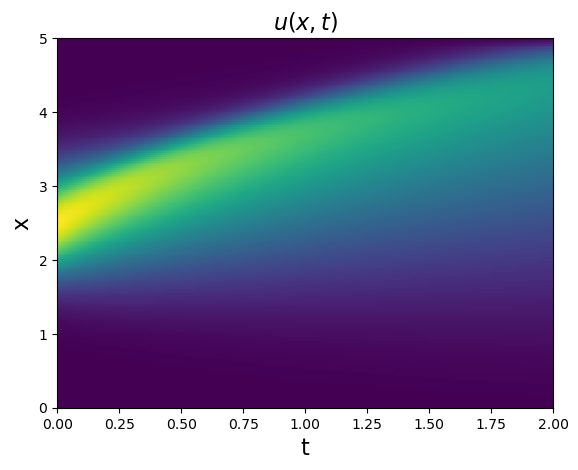

In [4]:
# Define and calculate constants and parameters

#Viscosity
# number between 0.003 and 0.3 (to maintain numerical stability)
epsilon_exp = 0.1

# Total size 
xmax = 5
# Total time
tmax = 2  

# Number of spatial grid points
nx_exp = 200
# Temporal resolution
dt_exp = 0.001

# Position vector
x_exp = np.linspace(0, xmax, nx_exp)
#  Number of temporal grid points
nt_exp = int(tmax / dt_exp)  
# Spatial resolution
dx_exp = xmax / nx_exp 
# Vector containing time points
t_exp = np.linspace(0, tmax, nt_exp)  
# Array containing velocity
u_exp = np.zeros([nx_exp-1, nt_exp]) 
x_exp_circ = (x_exp[:-1] + x_exp[1:])/2


def main_run_FDM(x,u, dt, dx, epsilon, max_time_iter):
    for t in range(max_time_iter):
        u[1:-1, t+1] = u[1:-1, t] + dt * (epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2 
                   - 0.25 * (u[2:, t]**2 - u[:-2, t]**2) / dx)
        #diffusion = epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2
        #flux = (u[1:-1, t]**2 - u[:-2, t]**2) /(2*dx)
        #u[1:-1, t+1] = u[1:-1,t] + dt * (diffusion - flux)
        #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) + dt * (diffusion - flux)
        #print(np.linalg.norm(u[:,t+1]))
    return u


u_exp[:, 0] = 2 * np.exp(-2 * (x_exp_circ - 0.5 * xmax)**2)  # Initial condition
u_exp[0, :] = 0  # Boundary condition at x=0
u_exp[-1, :] = 0  #  Boundary condition at x=xmax

u_exp = main_run_FDM(x_exp, u_exp,dt_exp, dx_exp, epsilon_exp, nt_exp-1)


plt.pcolormesh(t_exp, x_exp_circ, u_exp)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

In [5]:
x = x_exp
t = t_exp
dt_ = dt_exp
dx = dx_exp
u = u_exp
epsilon = epsilon_exp
nt = nt_exp
nx = nx_exp

In [6]:
# define simplicial complex
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()

In [7]:
x_circ = (x[:-1] + x[1:])/2
u_0 = np.zeros((len(x_circ), len(t)), dtype = dt.float_dtype)
u_0[:,0] =2 * np.exp(-2 * (x_circ - 0.5 * xmax)**2) 
u_0[0, :] = 0  
u_0[-1, :] = 0

In [8]:
def main_run(u, S, epsilon, max_time_iter, scheme="parabolic"):
    for t in range(max_time_iter):
        u_coch = C.CochainD0(S, u[:,t])
        du_coch = C.coboundary(u_coch)
        # impose periodic bc
        #du_coch.coeffs = du_coch.coeffs.at[0].set(0.5*(u_coch.coeffs[0] - u_coch.coeffs[-1]))
        #du_coch.coeffs = du_coch.coeffs.at[-1].set(0.5*(u_coch.coeffs[0] - u_coch.coeffs[-1]))
        dissipation = C.scalar_mul(C.star(du_coch), epsilon)
        #flux = C.scalar_mul(C.square(u_coch), -1/2)
        if scheme == "upwind":
            flat_u = flat(u_coch, scheme)
            flux = C.scalar_mul(C.square(C.star(flat_u)), -1/2)
        elif scheme == "parabolic":
            u_sq = C.scalar_mul(C.square(u_coch), -1/2)
            #print(u_sq.coeffs)
            flux = C.star(flat(u_sq, scheme))
            #print(flux.coeffs)
            #break
        #mean_flux = flat(flux, scheme)
        total_flux = C.add(flux, dissipation)
        balance = C.star(C.coboundary(total_flux))
        u[1:-1, t+1] = u[1:-1, t] + dt_*balance.coeffs[1:-1]
    return u

In [9]:
#epsilon = dx*2/dt_
u_data = main_run(u_0.copy(), S, epsilon, nt - 1, "parabolic")
u_sol = main_run(u_0.copy(), S, 0., nt - 1, "upwind")

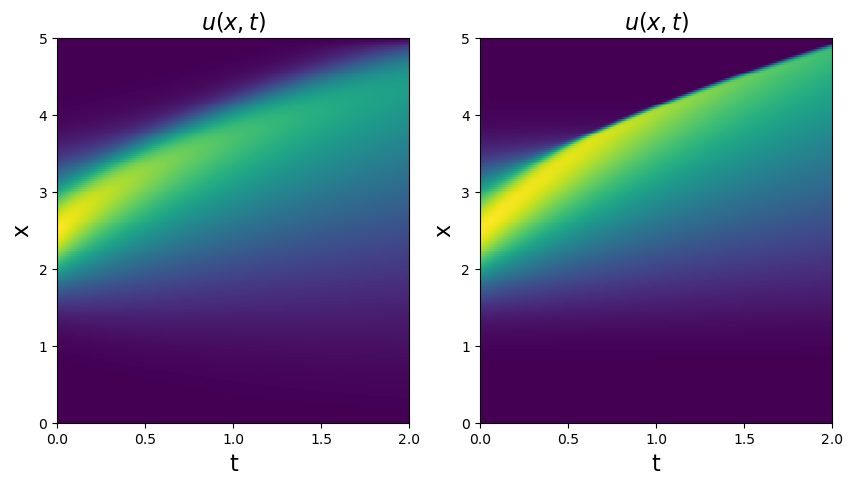

In [10]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x_circ, u_data)
ax[1].pcolormesh(t,x_circ,u_sol)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

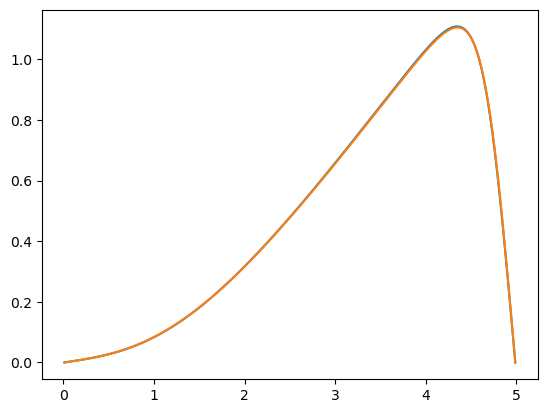

In [11]:
#plt.plot(x_circ[1700:], u_sol[1700:,-1], marker = ".", linewidth = 0.01)
plt.plot(x_circ[:], u_data[:,-1])
plt.plot(x_circ[:], u_exp[:,-1])
#plt.plot(x_circ[:1700], u_sol[:1700,-1], marker = ".", linewidth = 0.01)
plt.show()

In [12]:
np.mean(np.linalg.norm(u_data - u_exp, axis=0)**2)

0.0018568648351477586

In [14]:
print(u_exp[:,-1])

[0.         0.0011416  0.00228754 0.00344217 0.00460982 0.00579477
 0.00700132 0.00823369 0.00949607 0.01079261 0.01212738 0.0135044
 0.01492762 0.01640089 0.01792801 0.01951265 0.02115841 0.02286878
 0.02464713 0.02649673 0.02842073 0.03042216 0.03250391 0.03466874
 0.0369193  0.03925808 0.04168743 0.04420959 0.0468266  0.04954042
 0.05235283 0.05526545 0.0582798  0.06139722 0.06461892 0.06794596
 0.07137928 0.07491967 0.07856777 0.0823241  0.08618907 0.09016292
 0.09424582 0.09843778 0.10273872 0.10714843 0.11166661 0.11629286
 0.12102668 0.12586746 0.13081455 0.13586716 0.14102447 0.14628556
 0.15164946 0.15711513 0.16268147 0.16834732 0.17411149 0.17997273
 0.18592975 0.19198124 0.19812583 0.20436215 0.21068878 0.21710431
 0.22360727 0.23019621 0.23686965 0.24362612 0.25046411 0.25738214
 0.26437871 0.27145233 0.27860151 0.28582475 0.29312059 0.30048754
 0.30792415 0.31542896 0.32300054 0.33063746 0.33833832 0.3461017
 0.35392624 0.36181058 0.36975336 0.37775327 0.38580899 0.393919